In [17]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import os
import random

In [18]:
# !pip install -q kaggle
# from google.colab import files

In [19]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip

In [20]:
train_normal = glob('./chest_xray/train/NORMAL/*.jpeg')
train_pneumonia = glob('./chest_xray/train/PNEUMONIA/*.jpeg')

train_data = train_normal + train_pneumonia

test_normal = glob('./chest_xray/test/NORMAL/*.jpeg')
test_pneumonia = glob('./chest_xray/test/PNEUMONIA/*.jpeg')

test_data = test_normal + test_pneumonia

val_normal = glob('./chest_xray/val/NORMAL/*.jpeg')
val_pneumonia = glob('./chest_xray/val/PNEUMONIA/*.jpeg')

val_data = val_normal + val_pneumonia

train_data += val_data

# all_data = train_data + test_data + val_data

train_data = random.sample(train_data, len(train_data))
test_data = random.sample(test_data, len(test_data))

# shuffle = random.sample(all_data, len(all_data))

# train_data = shuffle[:int(len(shuffle) * 0.8)]
# test_data = shuffle[int(len(shuffle) * 0.8):]


In [21]:
print(len(train_data), len(test_data))

5232 624


In [22]:
class ChestXRay(Dataset):
  def __init__(self, data):
    self.data = data

    self.fpaths = [fpath for fpath in data]

    self.normalize = transforms.Normalize(mean=[0.485,
    0.456, 0.406],std=[0.229, 0.224, 0.225])

    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)

    self.targets = [fpath.split('/')[-2] == 'PNEUMONIA' for fpath in self.fpaths]


  def __len__(self): return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)

    return (
      im.float().to(device),
      torch.tensor([target]).float().to(device)
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([1.], device='cuda:0')


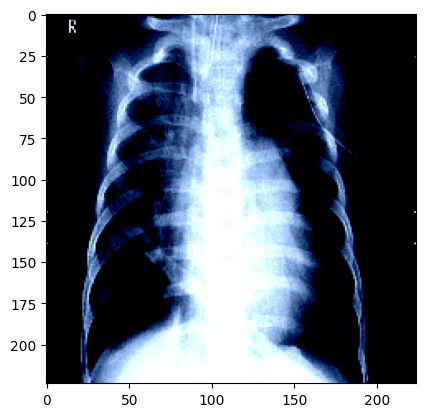

In [23]:
data = ChestXRay(train_data)
print(data)

im, label = data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [24]:
def get_model():
  model = models.resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.fc = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(512, 64),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            # nn.Linear(256, 128),
                            # nn.ReLU(),
                            # nn.Linear(128, 128),
                            # nn.ReLU(),
                            # nn.Linear(128, 64),
                            # nn.ReLU(),
                            nn.Linear(64, 1),
                            nn.Sigmoid())
  
  loss_fn = nn.BCELoss()
  parameter = model.parameters()
  optimizer = torch.optim.Adam(parameter,lr= 1e-3)
  return model.to(device), loss_fn, optimizer

In [25]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/bin/bash: line 1: /home/kaiserman/ML/transfer_learning_experiments/venv/bin/pip: cannot execute: required file not found


/home/kaiserman/ML/transfer_learning_experiments/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kaiserman/ML/transfer_learning_experiments/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [26]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [27]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [28]:
def get_data():
  train = ChestXRay(train_data)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
  drop_last = True)
  # test = ChestXRay(test_data)
  # test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last = True)
  val = ChestXRay(test_data)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [29]:
trn_dl, val_dl = get_data()

val = ChestXRay(val_data)
val_dl = DataLoader(val, batch_size=16, shuffle=True, drop_last = True)

print(trn_dl)
model, loss_fn, optimizer = get_model()

In [30]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(30):
  print(f" epoch {epoch + 1}/5")
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    # print(y)
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5
 epoch 6/5
 epoch 7/5
 epoch 8/5
 epoch 9/5
 epoch 10/5
 epoch 11/5
 epoch 12/5
 epoch 13/5
 epoch 14/5
 epoch 15/5
 epoch 16/5
 epoch 17/5
 epoch 18/5
 epoch 19/5
 epoch 20/5
 epoch 21/5
 epoch 22/5
 epoch 23/5
 epoch 24/5
 epoch 25/5
 epoch 26/5
 epoch 27/5
 epoch 28/5
 epoch 29/5
 epoch 30/5


/tmp/ipykernel_81589/1817668980.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


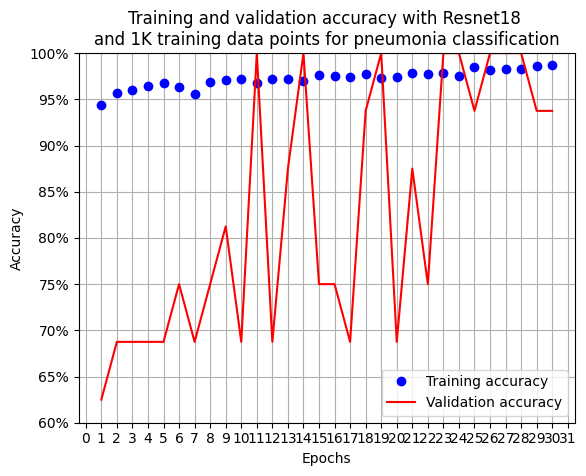

In [32]:
epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with Resnet18 \nand 1K training data points for pneumonia classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.6,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()